In [16]:
# Instalar dependencias necesarias en Google Colab
!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev
!pip install cython
!pip install cartopy cfgrib geopandas matplotlib pandas xarray netCDF4

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.11.1-1~jammy0).
libproj-dev is already the newest version (9.1.1-1~jammy0).
proj-bin is already the newest version (9.1.1-1~jammy0).
proj-data is already the newest version (9.1.1-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Descargado: shapefiles/peru/departamentos.shp
Descargado: shapefiles/peru/departamentos.dbf
Descargado: shapefiles/peru/departamentos.shx
Descargado: shapefiles/sudamerica/sudamerica.shp
Descargado: shapefiles/sudamerica/sudamerica.dbf
Descargado: shapefiles/sudamerica/sudamerica.shx
Descargado: data/pronostico.grib


Descargado: data/climatologia.nc
Rango de longitudes del pronóstico (convertido): -180.0 179.75
Rango de longitudes de la climatología (convertido): -90.0 -30.0
Dimensiones de dato_pronostico_peru: (77, 53)
Dimensiones de climatologia_peru: (77, 53)
Dimensiones de anomalía_porcentual: (77, 53)


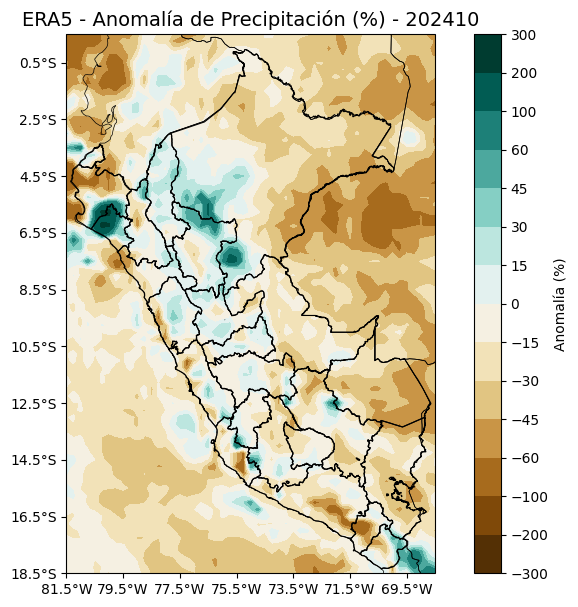

Gráfico guardado en /content/graphics/era5_202410_anomPrecip_peru.png


In [17]:
import os
import requests
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Función para descargar archivos
def download_file(url, local_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(local_path, "wb") as f:
            f.write(response.content)
        print(f"Descargado: {local_path}")
    else:
        print(f"Error al descargar {url}: Código {response.status_code}")

# Crear carpeta si no existe
def create_folder(path):
    os.makedirs(path, exist_ok=True)

# Convertir longitudes al rango [-180, 180]
def convert_longitudes(lon):
    return ((lon + 180) % 360) - 180

# Configuración inicial
FECHA_INICIAL = "202410"  # AAAAMM
lon_min, lon_max = -81.5, -68.5
lat_min, lat_max = -18.5, 0.5

# Rutas y descarga de datos
shapefiles_peru = {
    "departamentos.shp": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shp",
    "departamentos.dbf": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.dbf",
    "departamentos.shx": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/DEPARTAMENTOS.shx"
}
shapefiles_sudamerica = {
    "sudamerica.shp": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/SUDA_NUEVO_SIN_PERU_3.shp",
    "sudamerica.dbf": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/SUDA_NUEVO_SIN_PERU_3.dbf",
    "sudamerica.shx": "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape/SUDA_NUEVO_SIN_PERU_3.shx"
}
pronostico_url = f"https://raw.githubusercontent.com/Jorgellamocca/ERA5/main/data/flx_era5_pp_{FECHA_INICIAL}.grib"
climatologia_url = "https://raw.githubusercontent.com/Jorgellamocca/ERA5/main/data/clima_sudamerica_tp.nc"

# Descargar shapefiles
create_folder("shapefiles/peru")
create_folder("shapefiles/sudamerica")

for name, url in shapefiles_peru.items():
    download_file(url, f"shapefiles/peru/{name}")

for name, url in shapefiles_sudamerica.items():
    download_file(url, f"shapefiles/sudamerica/{name}")

# Descargar archivos de datos
create_folder("data")
download_file(pronostico_url, "data/pronostico.grib")
download_file(climatologia_url, "data/climatologia.nc")

# Cargar shapefiles
gdf_peru = gpd.read_file("shapefiles/peru/departamentos.shp")
gdf_sudamerica = gpd.read_file("shapefiles/sudamerica/sudamerica.shp")

# Cargar datasets
ds_pronostico = xr.open_dataset("data/pronostico.grib", engine="cfgrib")
ds_climatologia = xr.open_dataset("data/climatologia.nc")

# Seleccionar mes correspondiente en climatología
mes_pronostico = int(FECHA_INICIAL[4:])
climatologia_mes = ds_climatologia['tp'].sel(time=ds_climatologia['time.month'] == mes_pronostico).mean(dim='time')

# Convertir longitudes para consistencia
ds_pronostico['longitude'] = convert_longitudes(ds_pronostico['longitude'])
climatologia_mes['longitude'] = convert_longitudes(climatologia_mes['longitude'])

# Imprimir rangos de longitudes para verificar
print("Rango de longitudes del pronóstico (convertido):", ds_pronostico['longitude'].values.min(), ds_pronostico['longitude'].values.max())
print("Rango de longitudes de la climatología (convertido):", climatologia_mes['longitude'].values.min(), climatologia_mes['longitude'].values.max())

# Seleccionar región de Perú
dato_pronostico_peru = ds_pronostico['tp'].sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
climatologia_peru = climatologia_mes.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

# Verificar dimensiones y datos
print("Dimensiones de dato_pronostico_peru:", dato_pronostico_peru.shape)
print("Dimensiones de climatologia_peru:", climatologia_peru.shape)

# Calcular la anomalía porcentual
if dato_pronostico_peru.size > 0 and climatologia_peru.size > 0:
    anomalía_porcentual = np.where(climatologia_peru > 0,
                                   ((dato_pronostico_peru - climatologia_peru) / climatologia_peru) * 100,
                                   np.nan)
    print("Dimensiones de anomalía_porcentual:", anomalía_porcentual.shape)
else:
    raise ValueError("No se encontraron datos válidos dentro del rango seleccionado. Verifique los datos de entrada y las coordenadas.")

# Configurar el gráfico
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 7))

# Crear niveles y mapa de colores
niveles = np.concatenate([np.arange(-300, -60, 100), np.arange(-60, 61, 15), np.arange(100, 301, 100)])
cmap = plt.get_cmap('BrBG', len(niveles) - 1)
norm = BoundaryNorm(niveles, cmap.N)

# Graficar la anomalía porcentual
im = ax.contourf(dato_pronostico_peru['longitude'], dato_pronostico_peru['latitude'], anomalía_porcentual,
                 levels=niveles, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# Añadir shapefile de Perú
gdf_peru.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8, transform=ccrs.PlateCarree())

# Añadir shapefile de Sudamérica al final
gdf_sudamerica.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, transform=ccrs.PlateCarree(), zorder=5)

# Configurar detalles del mapa
ax.set_title(f"ERA5 - Anomalía de Precipitación (%) - {FECHA_INICIAL}", fontsize=14)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(lon_min, lon_max + 1, 2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_min, lat_max + 1, 2), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

# Barra de colores
cbar = fig.colorbar(im, ax=ax, orientation='vertical', label='Anomalía (%)')
cbar.set_ticks(niveles)

# Guardar figura
output_dir = "/content/graphics"
create_folder(output_dir)
output_path = f"{output_dir}/era5_{FECHA_INICIAL}_anomPrecip_peru.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Mostrar figura
plt.show()
print(f"Gráfico guardado en {output_path}")


Descargado: data/pronostico.grib


Descargado: data/climatologia.nc
Rango de longitudes del pronóstico (convertido): -180.0 179.75
Rango de longitudes de la climatología (convertido): -90.0 -30.0
Dimensiones de dato_pronostico_sudamerica: (301, 241)
Dimensiones de climatologia_sudamerica: (301, 241)
Dimensiones de anomalía_porcentual: (301, 241)


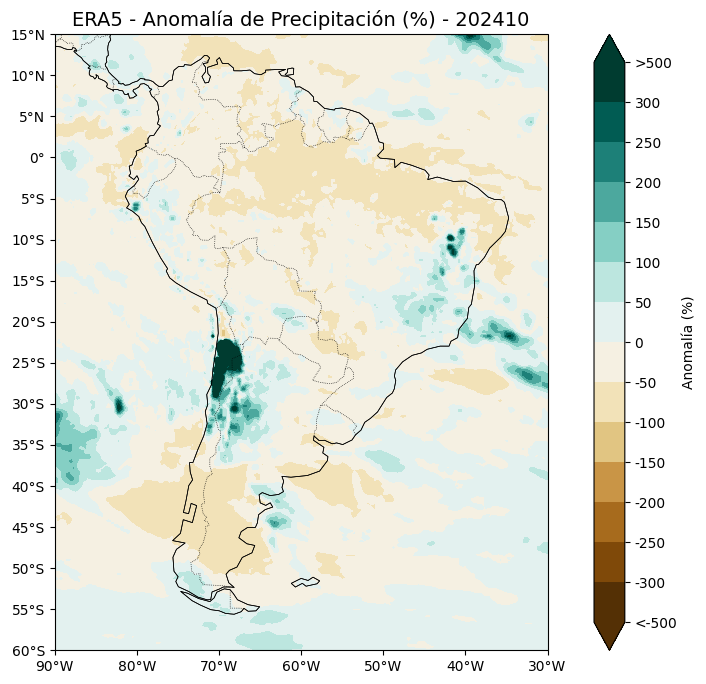

Gráfico guardado en /content/graphics/era5_202410_anomPrecip_sudamerica.png


In [15]:
# Instalar dependencias necesarias en Google Colab
#!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev
#!pip install cython
#!pip install cartopy cfgrib matplotlib pandas xarray netCDF4

import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Función para descargar archivos
def download_file(url, local_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(local_path, "wb") as f:
            f.write(response.content)
        print(f"Descargado: {local_path}")
    else:
        print(f"Error al descargar {url}: Código {response.status_code}")

# Crear carpeta si no existe
def create_folder(path):
    os.makedirs(path, exist_ok=True)

# Convertir longitudes al rango [-180, 180]
def convert_longitudes(lon):
    return ((lon + 180) % 360) - 180

# Configuración inicial
FECHA_INICIAL = "202410"  # AAAAMM
lon_min, lon_max = -90.0, -30.0
lat_min, lat_max = -60.0, 15.0  # Límite aproximado de Sudamérica

# Rutas y descarga de datos
pronostico_url = f"https://raw.githubusercontent.com/Jorgellamocca/ERA5/main/data/flx_era5_pp_{FECHA_INICIAL}.grib"
climatologia_url = "https://raw.githubusercontent.com/Jorgellamocca/ERA5/main/data/clima_sudamerica_tp.nc"

# Descargar archivos de datos
create_folder("data")
download_file(pronostico_url, "data/pronostico.grib")
download_file(climatologia_url, "data/climatologia.nc")

# Cargar datasets
ds_pronostico = xr.open_dataset("data/pronostico.grib", engine="cfgrib")
ds_climatologia = xr.open_dataset("data/climatologia.nc")

# Seleccionar mes correspondiente en climatología
mes_pronostico = int(FECHA_INICIAL[4:])
climatologia_mes = ds_climatologia['tp'].sel(time=ds_climatologia['time.month'] == mes_pronostico).mean(dim='time')

# Convertir longitudes para consistencia
ds_pronostico['longitude'] = convert_longitudes(ds_pronostico['longitude'])
climatologia_mes['longitude'] = convert_longitudes(climatologia_mes['longitude'])

# Imprimir rangos de longitudes para verificar
print("Rango de longitudes del pronóstico (convertido):", ds_pronostico['longitude'].values.min(), ds_pronostico['longitude'].values.max())
print("Rango de longitudes de la climatología (convertido):", climatologia_mes['longitude'].values.min(), climatologia_mes['longitude'].values.max())

# Seleccionar región de Sudamérica
dato_pronostico_sudamerica = ds_pronostico['tp'].sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
climatologia_sudamerica = climatologia_mes.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

# Verificar dimensiones y datos
print("Dimensiones de dato_pronostico_sudamerica:", dato_pronostico_sudamerica.shape)
print("Dimensiones de climatologia_sudamerica:", climatologia_sudamerica.shape)

# Calcular la anomalía porcentual
if dato_pronostico_sudamerica.size > 0 and climatologia_sudamerica.size > 0:
    anomalía_porcentual = np.where(climatologia_sudamerica > 0,
                                   ((dato_pronostico_sudamerica - climatologia_sudamerica) / climatologia_sudamerica) * 100,
                                   np.nan)
    print("Dimensiones de anomalía_porcentual:", anomalía_porcentual.shape)
else:
    raise ValueError("No se encontraron datos válidos dentro del rango seleccionado. Verifique los datos de entrada y las coordenadas.")

# Configurar el gráfico
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))

# Crear niveles y mapa de colores
niveles = np.concatenate([[-350], np.arange(-300, 301, 50), [350]])  # Añadir extremos
cmap = plt.get_cmap('BrBG', len(niveles) - 1)
norm = BoundaryNorm(niveles, cmap.N)

# Graficar la anomalía porcentual
im = ax.contourf(dato_pronostico_sudamerica['longitude'], dato_pronostico_sudamerica['latitude'], anomalía_porcentual,
                 levels=niveles, cmap=cmap, norm=norm, extend='both', transform=ccrs.PlateCarree())

# Añadir características de Cartopy
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, zorder=5)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none', linewidth=0.5, zorder=1)

# Configurar detalles del mapa
ax.set_title(f"ERA5 - Anomalía de Precipitación (%) - {FECHA_INICIAL}", fontsize=14)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(lon_min, lon_max + 10, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_min, lat_max + 5, 5), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

# Barra de colores
cbar = fig.colorbar(im, ax=ax, orientation='vertical', label='Anomalía (%)')
cbar.set_ticks(niveles)
cbar.ax.set_yticklabels(['<-500', *map(str, niveles[1:-1]), '>500'])

# Guardar figura
output_dir = "/content/graphics"
create_folder(output_dir)
output_path = f"{output_dir}/era5_{FECHA_INICIAL}_anomPrecip_sudamerica.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Mostrar figura
plt.show()
print(f"Gráfico guardado en {output_path}")
